In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Step 1: Extract the ZIP file
def extract_zip(zip_path, extract_to):
    """
    Extract the ZIP file to a specified directory.

    Args:
        zip_path (str): Path to the ZIP file.
        extract_to (str): Directory to extract the contents to.
    """
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted ZIP file to {extract_to}")

# Step 2: Load the data.yaml file
def load_data_yaml(yaml_path):
    """
    Load the data.yaml file to get dataset configuration.

    Args:
        yaml_path (str): Path to the data.yaml file.

    Returns:
        dict: Contents of the YAML file.
    """
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    return data



In [ ]:
if __name__ == "__main__":
    zip_path = "/content/drive/MyDrive/dataset_yolo/My First Project.v2i.yolov8.zip"  # Path to your ZIP file
    extract_to = "/content/drive/MyDrive/dataset_yolo/extracted"  # Directory to extract the dataset

    # Call the extract_zip function explicitly
    extract_zip(zip_path, extract_to)

    # Optionally, load the YAML file afterward
    yaml_path = os.path.join(extract_to, "data.yaml")
    if os.path.exists(yaml_path):
        data_config = load_data_yaml(yaml_path)
        print("Loaded YAML configuration:")
        print(data_config)
    else:
        print(f"No data.yaml found at {yaml_path}")

Extracted ZIP file to /content/drive/MyDrive/dataset_yolo/extracted
Loaded YAML configuration:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 11, 'names': ['Ascending Triangle', 'Cup and Handle', 'Descending Triangle', 'Double Bottom', 'Double Top', 'Falling Wedge', 'Head and Shoulder', 'Inverse Head and Shoulder', 'Symmetric Triangle', 'Triple Bottom Reversal', 'flag-and-pole'], 'roboflow': {'workspace': 'melvins', 'project': 'my-first-project-w0n2j', 'version': 2, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/melvins/my-first-project-w0n2j/dataset/2'}}


###  YOLOv8 Dataset Exploratory Data Analysis (EDA)


In [ ]:
import os
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


### Load Dataset Configuration

In [ ]:
dataset_dir = "/content/drive/MyDrive/dataset_yolo/extracted"
data_yaml_path = os.path.join(dataset_dir, "data.yaml")

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
num_classes = data_config['nc']

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

### Analyze Splits and Images

In [ ]:
splits = ['train', 'valid', 'test']
split_counts = {}
class_counts = defaultdict(lambda: defaultdict(int))
bbox_sizes, bbox_aspect_ratios, bbox_positions = [], [], []

for split in splits:
    image_dir = os.path.join(dataset_dir, split, 'images')
    label_dir = os.path.join(dataset_dir, split, 'labels')

    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        continue

    images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    split_counts[split] = len(images)

    for img_file in images:
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w, _ = img.shape

        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)

        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            annotations = f.readlines()

        for annotation in annotations:
            cls_id, xc, yc, bw, bh = map(float, annotation.split())
            cls_id = int(cls_id)
            cls_name = class_names[cls_id]
            class_counts[split][cls_name] += 1

            bbox_w, bbox_h = bw * w, bh * h
            bbox_sizes.append((cls_name, bbox_w, bbox_h))
            bbox_aspect_ratios.append((cls_name, bbox_w / bbox_h if bbox_h != 0 else 0))
            bbox_positions.append((xc, yc))


print("Split counts:", split_counts)


Split counts: {'train': 1176, 'valid': 289}


### Number of Images per Split

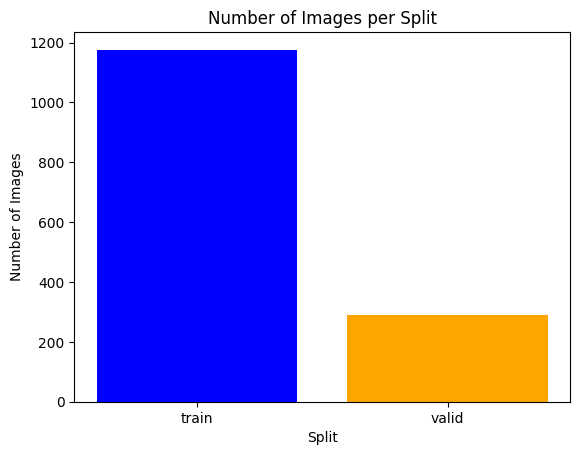

In [ ]:
plt.bar(split_counts.keys(), split_counts.values(), color=['blue', 'orange', 'green'])
plt.title("Number of Images per Split")
plt.xlabel("Split")
plt.ylabel("Number of Images")
plt.show()

### Class Distribution per Split

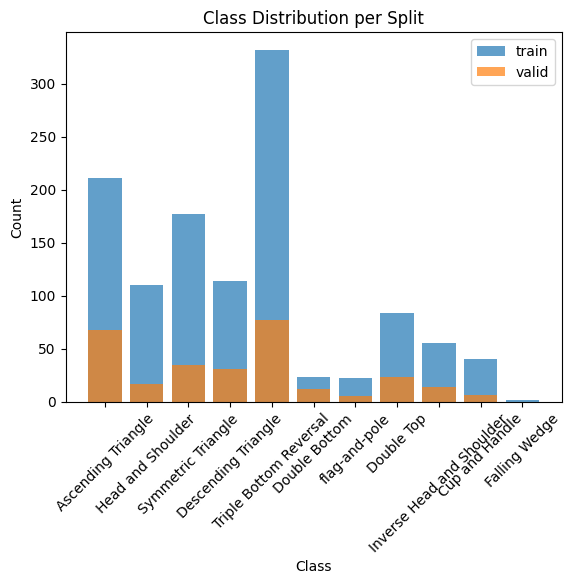

In [ ]:
for split in class_counts:
    plt.bar(class_counts[split].keys(), class_counts[split].values(), alpha=0.7, label=split)
plt.title("Class Distribution per Split")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Image Size Distribution

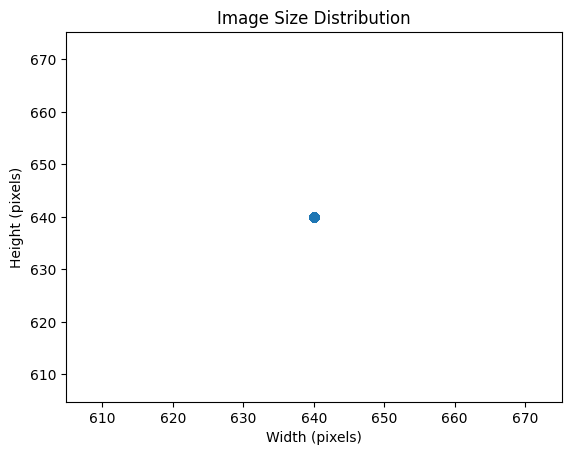

In [ ]:
widths, heights = zip(*image_sizes)
plt.scatter(widths, heights, alpha=0.5)
plt.title("Image Size Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

### bounding box aspect ratio

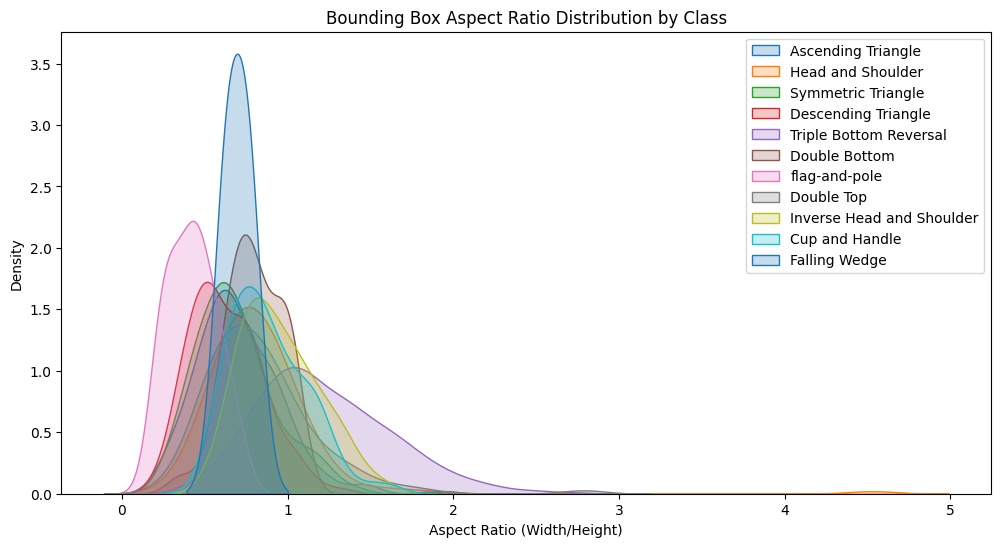

In [ ]:
aspect_ratios_by_class = defaultdict(list)
for cls, ratio in bbox_aspect_ratios:
    aspect_ratios_by_class[cls].append(ratio)

plt.figure(figsize=(12,6))
for cls in aspect_ratios_by_class:
    sns.kdeplot(aspect_ratios_by_class[cls], fill=True, label=cls)
plt.title("Bounding Box Aspect Ratio Distribution by Class")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Density")
plt.legend()
plt.show()



### Bounding box size analysis

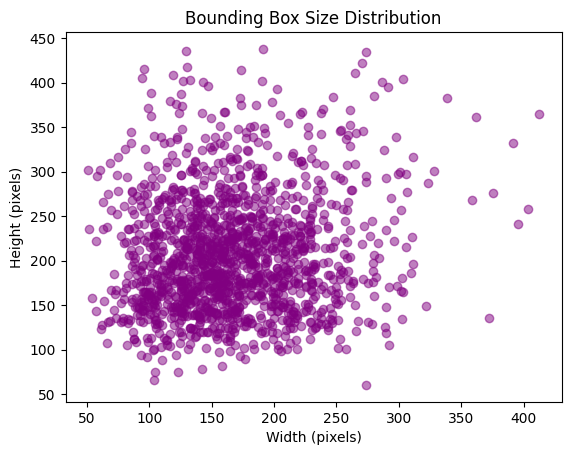

In [ ]:
bbox_w, bbox_h = zip(*bbox_sizes)
plt.scatter(bbox_w, bbox_h, alpha=0.5, color='purple')
plt.title("Bounding Box Size Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

### Bounding Box Position Heatmap

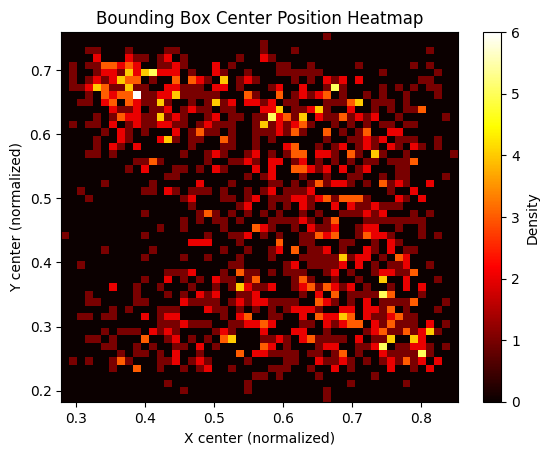

In [ ]:
x_pos, y_pos = zip(*bbox_positions)
plt.hist2d(x_pos, y_pos, bins=50, cmap='hot')
plt.title("Bounding Box Center Position Heatmap")
plt.xlabel("X center (normalized)")
plt.ylabel("Y center (normalized)")
plt.colorbar(label='Density')
plt.show()

### Visualise examples

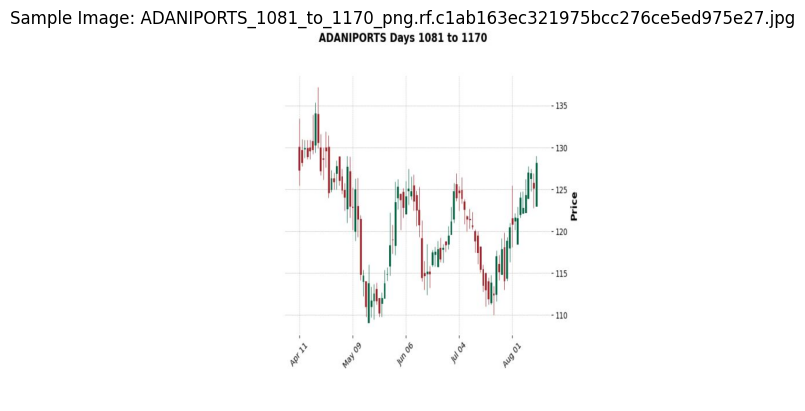

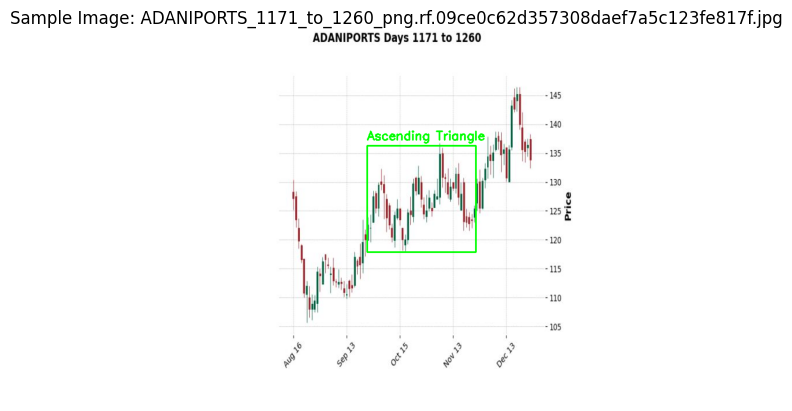

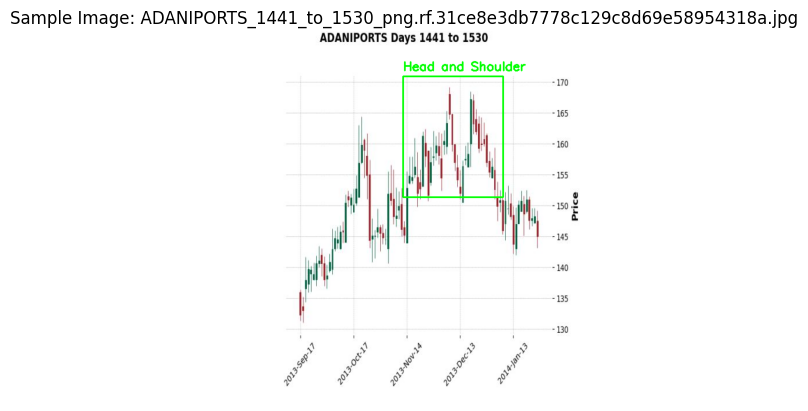

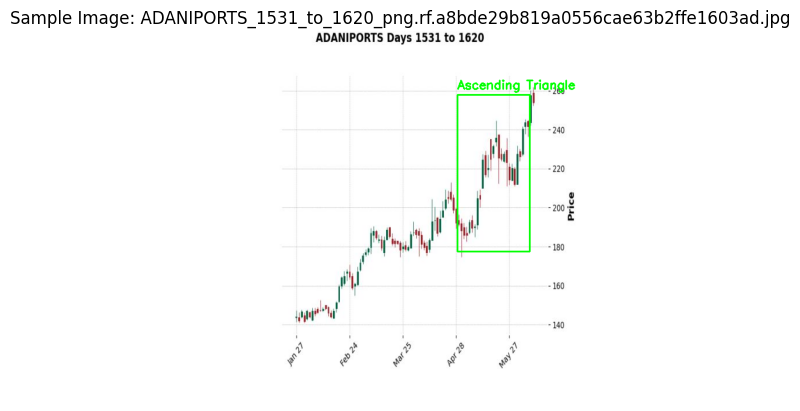

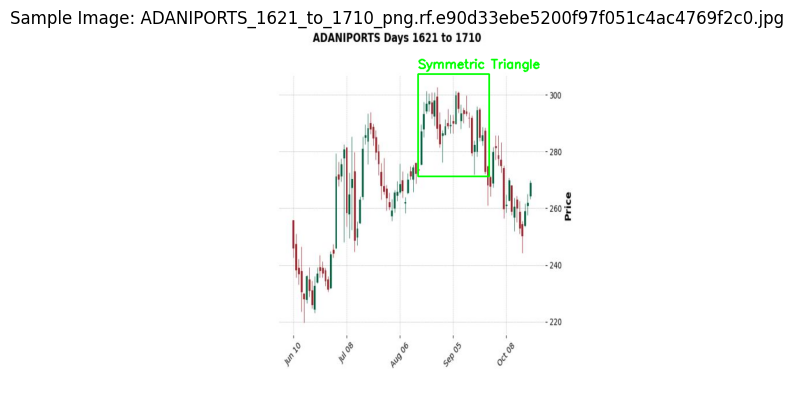

In [ ]:
num_samples = 5
image_dir = os.path.join(dataset_dir, 'train', 'images')
label_dir = os.path.join(dataset_dir, 'train', 'labels')

sample_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

for img_file in sample_images:
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    with open(label_path, 'r') as f:
        annotations = f.readlines()

    for annotation in annotations:
        cls_id, xc, yc, bw, bh = map(float, annotation.split())
        cls_id = int(cls_id)
        x1, y1 = int((xc - bw / 2) * w), int((yc - bh / 2) * h)
        x2, y2 = int((xc + bw / 2) * w), int((yc + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, class_names[cls_id], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Sample Image: {img_file}")
    plt.show()


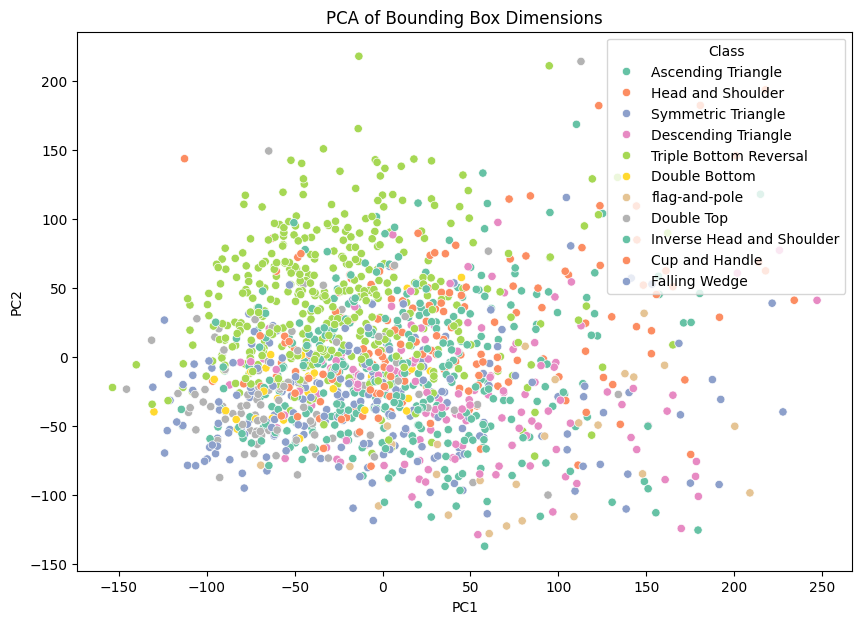

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Prepare data
bbox_sizes_df = pd.DataFrame(bbox_sizes, columns=['Class', 'Width', 'Height'])
bbox_sizes_df.head()

# Prepare data
bbox_dimensions = bbox_sizes_df[['Width', 'Height']].values
pca = PCA(n_components=2)
principal_components = pca.fit_transform(bbox_dimensions)

bbox_sizes_df['PC1'] = principal_components[:, 0]
bbox_sizes_df['PC2'] = principal_components[:, 1]

# Plot PCA results
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=bbox_sizes_df, palette='Set2')
plt.title('PCA of Bounding Box Dimensions')
plt.show()
